# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
#### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

#### Обратите внимание: 
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Откроем файлы с данными и изучим общую информацию

Загрузим все необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

Откроем файлы с данными и сохраним в переменных

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Рассмотрим общую информацию о датасетах

#### Звонки

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [5]:
calls.duplicated().sum()

0

In [6]:
len(calls[calls['duration'] < 1])

47927

Вывод:
- Перевести call_date в формат datetime64
- Было сказано, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Предлагаю заменить все значения меньше 1 на 1 в столбце duration.

<font color='brown'>Да, но что делать со звонками, длительность которых равна *нулю*?

#### Интернет-сессии

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [9]:
internet.duplicated().sum()

0

In [10]:
len(internet[internet['mb_used'] < 1])

19699

Вывод
- Изменить формат session_date на datetime64
- Округлить минимальное 0 до 1 в столбце md_used

#### Сообщения

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Вывод
- Изменить формат в столбце message_date в datetime64

#### Тарифы

In [12]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [13]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Вывод
- Переименовать столбец "tariff_name" в "tariff"
- Указаны цены за гигабайт, а количество трафика на месяц указаны в мегабайтах

#### Пользователи

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
users.duplicated().sum()

0

In [16]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [17]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Вывод
- Изменить форматы в столбцах reg_date и churn_date
- 462 абонента пользуются тарифами Смарт и Ультра

<font color='green'>Данные загружены и изучены. Используются верные методы для получения общей информации о таблице. Намечен план действий, отлично.

## Подготовим данные

#### Округлим числа и заполним пропуски

In [18]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'].where(calls['duration'] > 0, 1, inplace=True)

internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'].where(internet['mb_used'] > 0, 1, inplace=True)

In [19]:
internet['mb_used'] = internet['mb_used'].astype('int64')
calls['duration'] = calls['duration'].astype('int64')

<s><font color='brown'>Молодец, что не забываешь здесь округлить, но теперь данные целочисленные, так что имеет смысл сразу поменять тип.

#### Изменим форматы

In [20]:
def fix_datetime(df, columns):
    for column in columns:
        df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
        
fix_datetime(calls, ['call_date'])
fix_datetime(users, ['reg_date', 'churn_date'])
fix_datetime(messages, ['message_date'])
fix_datetime(internet, ['session_date'])

<font color=green>Отличная автоматизация.

Переименуем столбец tariff_name

In [21]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

In [22]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Посчитаем данные для каждого пользователя

Рассчитаем звонки для каждого абонента по месяцам

In [23]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [24]:
calls_for_month = calls.pivot_table(index=['month','user_id'],
                             values='duration',
                             aggfunc=['count', 'sum'])

Создали временную переменную для хранения данных со сводных таблиц

In [25]:
temporary_df = pd.DataFrame(calls_for_month.to_records())

Создали новую таблицу где посчитаем траты для каждого пользователя

In [26]:
monthly_revenue = pd.DataFrame()

In [27]:
monthly_revenue['user_id'] = temporary_df['user_id']
monthly_revenue['month']   = temporary_df['month']
monthly_revenue['calls']   = temporary_df.iloc[:, 2]
monthly_revenue['minutes'] = temporary_df.iloc[:, 3]

Рассчитаем сообщения для каждого абонента по месяцам

In [28]:
messages['month'] = messages['message_date'].dt.month

In [29]:
messages_for_month = messages.pivot_table(
    index=['month', 'user_id'],
    values='id',
    aggfunc='count')

In [30]:
temporary_df = pd.DataFrame(messages_for_month.to_records()).rename(columns={'id': 'messages'})

In [31]:
monthly_revenue = monthly_revenue.merge(temporary_df, on=['user_id', 'month'], how='outer')

Рассчитаем интернет трафик для каждого пользователя

In [32]:
internet['month'] = internet['session_date'].dt.month

In [33]:
internet_for_month = internet.pivot_table(index=['month', 'user_id'],
                                         values='mb_used',
                                         aggfunc='sum')

In [34]:
temporary_df = pd.DataFrame(internet_for_month.to_records())

In [35]:
monthly_revenue = monthly_revenue.merge(temporary_df, on=['user_id', 'month'], how='outer')

In [36]:
monthly_revenue

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15.0,99.0,7.0,2730.0
1,1032,1,61.0,397.0,38.0,24158.0
2,1045,1,1.0,9.0,5.0,2348.0
3,1055,1,64.0,568.0,30.0,17115.0
4,1071,1,24.0,200.0,16.0,15625.0
...,...,...,...,...,...,...
3209,1231,12,NaN,NaN,191.0,32483.0
3210,1328,12,NaN,NaN,7.0,39465.0
3211,1473,12,NaN,NaN,20.0,18433.0
3212,1489,12,NaN,NaN,35.0,17349.0


In [37]:
monthly_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3174 non-null float64
minutes     3174 non-null float64
messages    2717 non-null float64
mb_used     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


Создали отдельную таблицу, где рассчитали звонки, сообщения и потраченный интернет трафик за месяц для каждого абонента. 
- В некоторых в строках отсутствуют значения. Возможно это объясняется тем, что абонент не пользовался услугами в определенный месяц. 
- После соединения таблиц, форматы данных в столбцах изменились на float64

<font color='green'>Так или иначе, в таблицы успешно добавлена информация о месяцах. Данные аггрегированы и объеденены верно.

In [38]:
fix_columns = ['calls', 'minutes', 'messages']

for column in fix_columns:
    monthly_revenue[column] = monthly_revenue[column].fillna(0).astype('int64')

Рассчитаем помесячную выручку с каждого абонента

In [39]:
monthly_revenue = monthly_revenue.merge(users, on='user_id', how='left').merge(tariffs, on='tariff', how='left')

In [40]:
monthly_revenue = monthly_revenue.drop(['first_name', 'last_name', 'age'], axis='columns')

In [41]:
monthly_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 17 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
calls                    3214 non-null int64
minutes                  3214 non-null int64
messages                 3214 non-null int64
mb_used                  3203 non-null float64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(12), object(2)
memory usage: 452.0+ KB


<s><font color='brown'>Здесь имеет смысл взять из таблицы users только необходимые столбцы, чтобы не таскать за собой ненужные данные типа имени.

Вычтим бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика

In [42]:
monthly_revenue['minutes_extra']  = monthly_revenue['minutes'] - monthly_revenue['minutes_included']
monthly_revenue['messages_extra'] = monthly_revenue['messages'] - monthly_revenue['messages_included']
monthly_revenue['mb_used_extra']  = monthly_revenue['mb_used'] - monthly_revenue['mb_per_month_included']

Положительные значения говорят о перерасходе, а отрицательные о не потраченных минутах/трафика/сообщений.
Остаток нужно умножить на значения из тарифного плана

In [43]:
def count_monthly_revenue(row):
    price_minutes= 0
    price_messages = 0
    price_mb = 0
    
    if row['minutes_extra'] > 0:
        minutes_price = row['minutes_extra'] * row['rub_per_minute']
        
    if row['messages_extra'] > 0:
        messages_price = row['messages_extra'] * row['rub_per_message']
        
    if row['mb_used_extra'] > 0:
        price_mb = (row['mb_used_extra'] / 1024) * row['rub_per_gb']
        
    return price_minutes + price_messages + price_mb

<font color='brown'>Здесь потраченные гигабайты можно округлить вверх, обычно операторы, указывая цену за гигабайт, считают именно так.

Прибавили абонентскую плату, соответствующую тарифному плану

In [44]:
monthly_revenue['rub_monthly_fee_extra'] = monthly_revenue.apply(count_monthly_revenue, axis=1)
monthly_revenue['rub_monthly_fee_total'] = monthly_revenue['rub_monthly_fee'] + monthly_revenue['rub_monthly_fee_extra']

<font color='green'>Но в целом прибыль рассчитана верно. Молодец, что подтягиваешь тарифы напрямую из таблицы, а не используешь константы. При смене тарифов код переписывать не придется.

## Проанализируем данные

Опишим поведение клиентов оператора, исходя из выборки. Создадим сводную таблицу по тарифам, относительно месяцев.

In [45]:
tariff_monthly_price = monthly_revenue.pivot_table(
    index=['tariff', 'month'],
    values=['minutes', 'messages', 'mb_used', 'rub_monthly_fee_extra', 'rub_monthly_fee_total'])

Найдем количество минут, сообщений и интернет-трафика требуется пользователям каждого тарифа в месяц

In [46]:
tariff_using = tariff_monthly_price.pivot_table(index='tariff', 
                                                values=['minutes', 
                                                        'messages', 
                                                        'mb_used', 
                                                        'rub_monthly_fee_extra', 
                                                        'rub_monthly_fee_total'])

In [47]:
tariff_using

,mb_used,messages,minutes,rub_monthly_fee_extra,rub_monthly_fee_total
tariff,,,,,
smart,15091.033082,31.413211,397.374228,464.140899,1014.140899
ultra,18445.022099,43.714983,509.356551,88.972927,2038.972927


Вывод:
- Абоненты с тарифом Ультра более активны, но абоненты с тарифом Смарт тратят больше на дополнительные минуты/сообщения/трафик
- Несмотря на вышесказанный пункт, абоненты тарифа Ультра тратят больше денег

#### Средняя выручка пользователей из Москвы и других регионов

In [48]:
moscow_price = monthly_revenue['city'] == 'Москва'
monthly_revenue['city'].where(moscow_price, 'Другой регион', inplace=True)

In [49]:
city_monthly_price = monthly_revenue.pivot_table(
    index = ['city', 'month'],
    values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_extra', 'rub_monthly_fee_total'])

In [50]:
city_using = city_monthly_price.pivot_table(
    index = 'city', 
    values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_extra', 'rub_monthly_fee_total'])
city_using

,mb_used,messages,minutes,rub_monthly_fee_extra,rub_monthly_fee_total
city,,,,,
Другой регион,15758.440143,35.268458,424.594742,356.272213,1302.812260
Москва,17603.175813,33.944639,455.792652,318.973519,1413.938788


Вывод
- В Москве абоненты потребляют больше интернет-трафика. Возможно связано с тем, что в городе больше интернет покрытий
- Также, в столице используют больше минут разговора\сообщений, но разница не велика
- В других регионах тратят больше денег на дополнительные пакеты услуг

### Посчитаем среднее количество, дисперсию и стандартное отклонение

Поделим данные по тарифам

In [51]:
smart_tariff = monthly_revenue.query("tariff == 'smart'")
ultra_tariff = monthly_revenue.query("tariff == 'ultra'")

In [52]:
len(smart_tariff)

2229

In [53]:
len(ultra_tariff)

985

Минуты

In [54]:
smart_tariff['minutes'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: minutes, dtype: float64

In [55]:
ultra_tariff['minutes'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: minutes, dtype: float64

Стандартное отклонения по услуге разговорных минут:
- Смарт - 194.87
- Ультра - 325.73

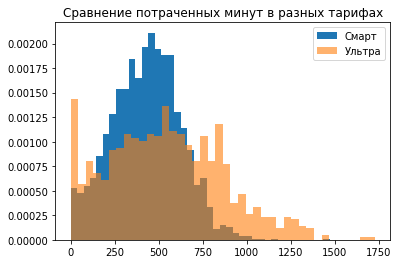

In [56]:
plt.title('Сравнение потраченных минут в разных тарифах')
plt.hist(smart_tariff['minutes'], bins=40, label='Смарт', density=True)
plt.hist(ultra_tariff['minutes'], bins=40, label='Ультра', alpha=0.6, density=True)
plt.legend(loc='upper right')
plt.show()

<b>UPD <font color=green>Вот, теперь красота.

In [57]:
var_smart_minutes = np.var(smart_tariff['minutes'])
var_ultra_minutes = np.var(ultra_tariff['minutes'])

In [58]:
var_smart_minutes

37957.737941136875

In [59]:
var_ultra_minutes

105998.00527300368

Сообщения

In [60]:
smart_tariff['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [61]:
ultra_tariff['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

Стандартное отклонения по услуге сообщений:
- Смарт - 28.22
- Ультра - 47.8

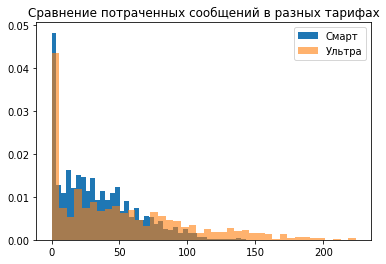

In [62]:
plt.title('Сравнение потраченных сообщений в разных тарифах')
plt.hist(smart_tariff['messages'], bins=40, label='Смарт', density=True)
plt.hist(ultra_tariff['messages'], bins=40, label='Ультра', alpha=0.6, density=True)
plt.legend(loc='upper right')
plt.show()

In [63]:
var_smart_messages = np.var(smart_tariff['messages'])
var_ultra_messages = np.var(ultra_tariff['messages'])

In [64]:
var_smart_messages

796.455482917076

In [65]:
var_ultra_messages

2282.9460753948824

Интернет-трафик

In [66]:
smart_tariff['mb_used'].describe()

count     2228.000000
mean     16244.472172
std       5871.037024
min          1.000000
25%      12673.250000
50%      16541.500000
75%      20078.750000
max      38627.000000
Name: mb_used, dtype: float64

In [67]:
ultra_tariff['mb_used'].describe()

count      975.000000
mean     19688.587692
std       9952.830482
min          1.000000
25%      12022.000000
50%      19416.000000
75%      26921.500000
max      49793.000000
Name: mb_used, dtype: float64

Стандартное отклонения по услуге интернет-трафика:
- Смарт - 5871.03
- Ультра - 9952.83

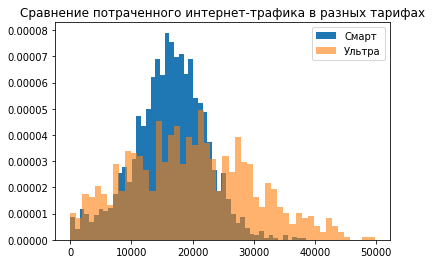

In [68]:
plt.title('Сравнение потраченного интернет-трафика в разных тарифах')
plt.hist(smart_tariff['mb_used'], bins=50, label='Смарт', density=True)
plt.hist(ultra_tariff['mb_used'], bins=50, label='Ультра', density=True, alpha=0.6)
plt.legend(loc='upper right')
plt.show()

In [69]:
var_smart_mb_used = np.var(smart_tariff['mb_used'])
var_ultra_mb_used = np.var(ultra_tariff['mb_used'])

In [70]:
var_smart_mb_used

34453604.87848954

In [71]:
var_ultra_mb_used

98957235.80128442

- Абонентам тарифа Смарт не хватает выделенного пакета услуг. Они чаще переплачивают за дополнительные минуты и интернет-трафик
- Также большое количество людей в тарифе Смарт не пользуются сообщениями
- Абоненты тарифа Ультра, наоборот, чаще всего не тратят до конца выделенные 3000 минут и 1000 сообщений

## Проверим гипотезы

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается или нет

In [72]:
smart_tariff['rub_monthly_fee_total'].mean()

1092.2172043236878

In [73]:
ultra_tariff['rub_monthly_fee_total'].mean()

2060.591390387056

Сформулируем Нулевые гипотезы подобным образом:
    - Нулевая гипотеза H₀: Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
    - Альтернативная гипотеза H₁: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [74]:
alpha = .01

results = st.ttest_ind(
    smart_tariff['rub_monthly_fee_total'], 
    ultra_tariff['rub_monthly_fee_total'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.725353702885943e-294
Отвергаем нулевую гипотезу


Результат говорит о том, что средняя выручка от тарифов различаются

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов или нет

In [75]:
monthly_revenue.query("city == 'Москва'")['rub_monthly_fee_total'].mean()

1425.675202664689

In [76]:
monthly_revenue.query("city == 'Другой регион'")['rub_monthly_fee_total'].mean()

1380.386907084374

Сформулируем Нулевые гипотезы:
    - Нулевая гипотеза H₀: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
    - Альтернативная гипотеза H₁: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [77]:
moscow_revenue = monthly_revenue.query("city == 'Москва'")['rub_monthly_fee_total']
other_cities_revenue = monthly_revenue.query("city == 'Другой регион'")['rub_monthly_fee_total']

alpha = .01

results = st.ttest_ind(moscow_revenue, other_cities_revenue)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.186928363764759
Не получилось отвергнуть нулевую гипотезу


Полученное p-значение говорит: если предположим, что выручки различаются, мы ошибемся в 18% случаев. Что, для нас непримелемо.

## Общий вывод

- Абоненты с тарифом Смарт тратят больше на дополнительные минуты/сообщения/трафик
- Тариф Ультра более выгоден телефоной компании, так как абоненты тратят больше денег и не выходят за рамки количества приобретенных минут\сообщений\интернет-трафика
- В Москве абоненты потребляют больше интернет-трафика. Возможно связано с тем, что в городе больше интернет-покрытий
- В других регионах тратят больше денег на дополнительные пакеты услуг. Возможно связано с недостатком тех же самых интернет-покрытий
- Средняя выручка Москвы не отличается от других регионов

---